In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from six.moves import cPickle as pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from time import time

In [3]:
#output files
pickle_file = 'Xgb_4.pickle'
output_file = 'sub_4.csv'

In [70]:
# read train,test,sample and macro datasets

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
macro = pd.read_csv('macro.csv')
sample = pd.read_csv('sample_submission.csv')


Understand Date

In [52]:
train['timestamp'] = pd.to_datetime(train.timestamp)
test['timestamp'] = pd.to_datetime(test.timestamp)
macro['timestamp'] = pd.to_datetime(macro.timestamp)

In [53]:
train.timestamp.dt.weekofyear[:5]

0    33
1    34
2    34
3    35
4    36
Name: timestamp, dtype: int64

In [54]:
def make_datetime_features(df):
    df['dayofweek'] = df.timestamp.dt.dayofweek
    df['weekofyear'] = df.timestamp.dt.weekofyear
    df['year'] = df.timestamp.dt.year
    df['month'] = df.timestamp.dt.month
    return df
    

In [55]:
train = make_datetime_features(train)
test = make_datetime_features(test)

In [56]:
train['ln_price_doc'] = np.log(train.price_doc)

In [57]:
#define the train data test data and train label
X = train.drop(['id','timestamp','price_doc'],axis = 1)
y = np.log(train.price_doc)

X_new = test.drop(['id','timestamp'],axis=1)

In [58]:
%matplotlib inline

In [75]:
1/train.floor

0        0.250000
1        0.333333
2        0.500000
3        0.111111
4        0.250000
5        0.071429
6        0.100000
7        0.200000
8        0.200000
9        0.111111
10       0.083333
11       0.090909
12       0.250000
13       0.250000
14       0.333333
15       0.066667
16       0.250000
17       0.500000
18       0.100000
19       0.250000
20       0.100000
21       0.142857
22       0.166667
23       0.333333
24       0.090909
25       0.111111
26       0.250000
27       0.166667
28       0.066667
29       0.333333
           ...   
30441    0.038462
30442    0.500000
30443    0.058824
30444    0.050000
30445    0.052632
30446    0.125000
30447    0.066667
30448    0.125000
30449    0.142857
30450    0.200000
30451    0.333333
30452    0.142857
30453    0.166667
30454    0.333333
30455    0.333333
30456    0.125000
30457    0.142857
30458    0.142857
30459    0.250000
30460    0.125000
30461    0.200000
30462    0.043478
30463    0.076923
30464    0.052632
30465    0

In [72]:
num_train_df

Index(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=276)

In [74]:
def impute_missing(t1,t2):
    #imp_cat = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 1)
    imp = Imputer(missing_values = 'NaN',strategy = 'mean', axis = 1)
    #imp_cat.fit(t1[Cat_features])
    imp = imp.fit(t1[num_train_df])
    #imp_cat.transform(t1[Cat_features])
    #imp_cat.transform(t2[Cat_features])
    t1[num_train_df] = imp.transform(t1[num_train_df])
    t2[num_train_df] = imp.transform(t2[num_train_df])
    
    
    return t1, t2
train, test = impute_missing(train,test)

KeyError: "Index(['price_doc'], dtype='object') not in index"

In [49]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43.0,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000
1,2,2011-08-23,34.0,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000
2,3,2011-08-27,43.0,29.0,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000
3,4,2011-09-01,89.0,50.0,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000
4,5,2011-09-05,77.0,77.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452


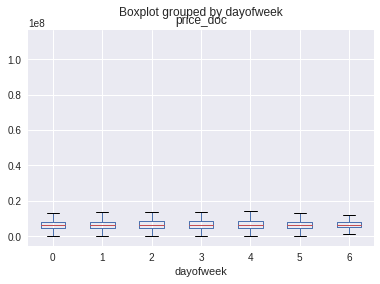

In [11]:
train.boxplot('price_doc',by = 'dayofweek')

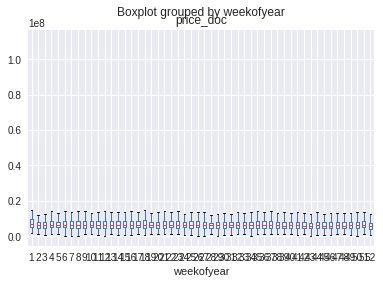

In [12]:
train.boxplot('price_doc',by = 'weekofyear')

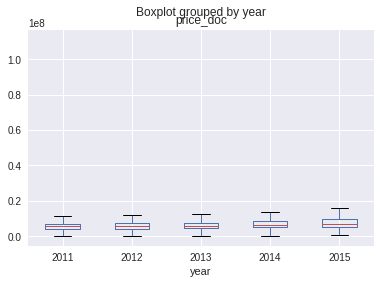

In [13]:
train.boxplot('price_doc',by = 'year')

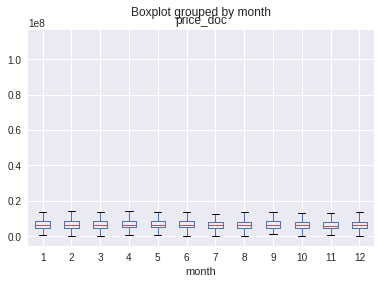

In [14]:
train.boxplot('price_doc',by = 'month')

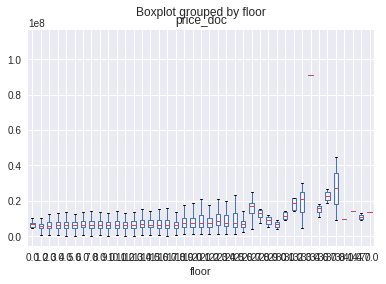

In [15]:
train.boxplot('price_doc',by = 'floor')

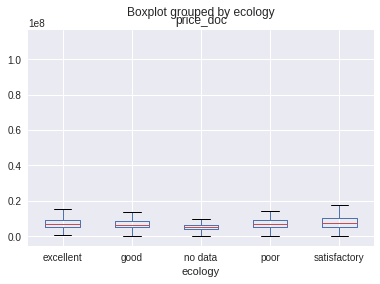

In [16]:
train.boxplot('price_doc',by = 'ecology')

Join the train and test with macro to get additional features

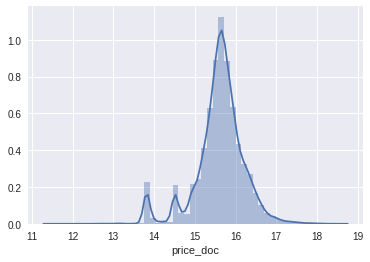

In [17]:
sns.distplot(np.log(train.price_doc))

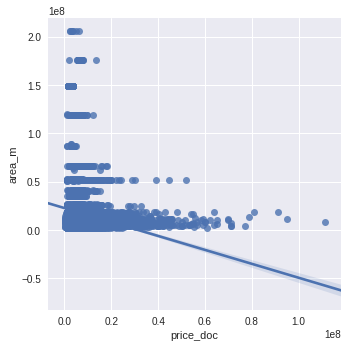

In [18]:
sns.set(style="darkgrid")
# Make a custom palette with gendered colors
#pal = dict(male="#6495ED", female="#F08080")
sns.lmplot(x="price_doc", y="area_m",data = train)

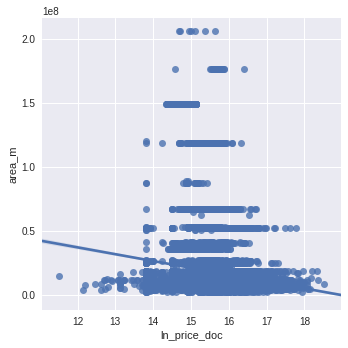

In [19]:
sns.lmplot(x="ln_price_doc", y="area_m",data = train)

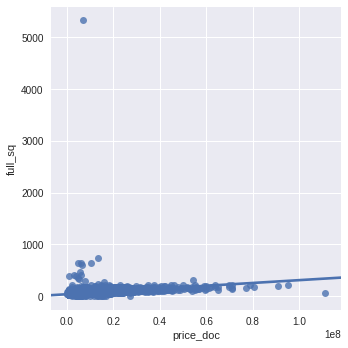

In [20]:
sns.lmplot(x="price_doc", y="full_sq",data = train)

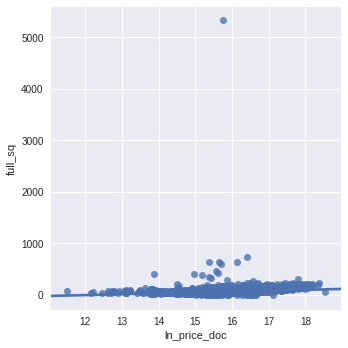

In [21]:
sns.lmplot(x="ln_price_doc", y="full_sq",data = train)

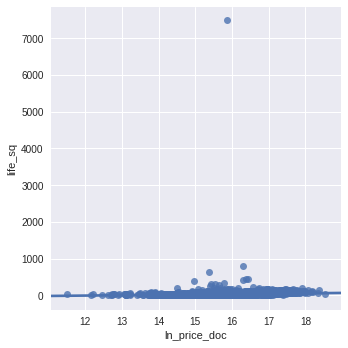

In [22]:
sns.lmplot(x="ln_price_doc", y="life_sq",data = train)

In [23]:
#fill NaN values with 0

train = train.fillna(0)
test = test.fillna(0)

In [13]:
# encode the ctegorical variables
le = LabelEncoder()

FeatureNames = train.columns[1:-1]

Cat_features = []
for c in FeatureNames:
    if train[c].dtypes.name == 'object':
        Cat_features.append(c)
print(Cat_features)

for col in Cat_features:
    le.fit(np.append(train[col].astype(str), test[col].astype(str)))
    train[col] = le.transform(train[col].astype(str)).astype(int)
    test[col] = le.transform(test[col].astype(str)).astype(int)

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']


In [45]:
def get_macro_features(df):
    return pd.merge(df, macro, on='timestamp', how='left')

In [46]:
train_macro = get_macro_features(train)
test_macro = get_macro_features(test)

In [49]:
train_macro.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,0.0,0.0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,0.0,0.0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,0.0,0.0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,0.0,0.0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


In [50]:
#define the train data test data and train label
X = train.drop(['id','timestamp','price_doc','ln_price_doc'],axis = 1)
y = train.ln_price_doc

X_new = test.drop(['id','timestamp'],axis=1)

In [51]:
xgb_model = xgb.XGBRegressor()
param_grid = {}
param_grid['max_depth'] = [4,8]
param_grid['n_estimators'] = [100,200]
param_grid['learning_rate'] = [0.05,0.07,0.1]

In [ ]:
if not os.path.isfile(pickle_file):
    clf = GridSearchCV(xgb_model,param_grid,scoring = 'r2',verbose = 1,cv = 5,n_jobs = -1)
    clf.fit(X,y)
    try:
        with open(pickle_file,'wb') as f:
            pickle.dump(clf,f,pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save output to ',pickle_filename, ':',e)


else:
    #Pickle the output
    with open(pickle_file,'rb') as f:
        save = pickle.load(f)
        clf = save['clf']
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
y_pred = clf.predict(X_new)

y_out = np.exp(y_pred)

#Create a DataFrame that only contains the IDs and predicted values
if not os.path.isfile(output_file):
    pd.DataFrame({'id':test.id, 'price_doc': y_out}).set_index('id').to_csv(output_file)
else:
    print('Output file', output_file, ' already exists into the location')

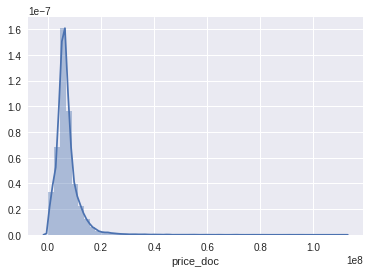

In [7]:
sns.distplot(train.price_doc)


In [5]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


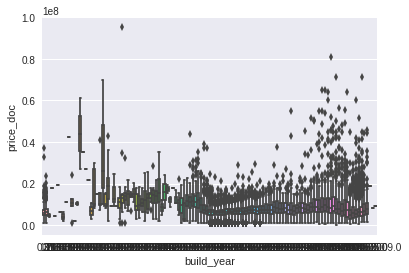

In [9]:
sns.boxplot(data=train,y="price_doc",x="build_year")

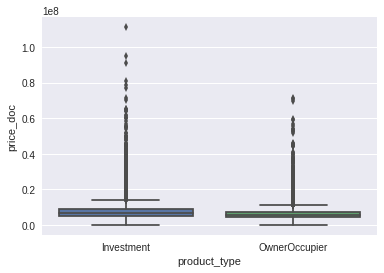

In [12]:
sns.boxplot(data=train,y="price_doc",x="product_type")

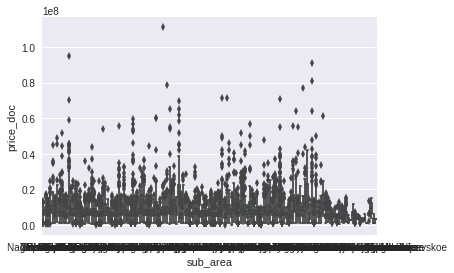

In [13]:
sns.boxplot(data=train,y="price_doc",x="sub_area")

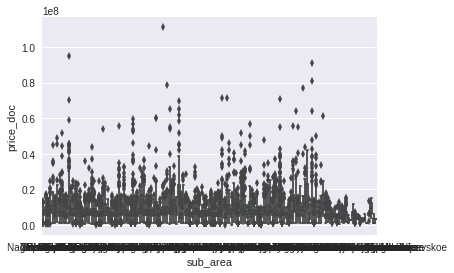

In [14]:
sns.boxplot(data=train,y="price_doc",x="sub_area")

In [ ]:
sns.pairplot(train)